In [19]:
# pip install openpyxl ffmpeg


In [20]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from IPython.display import HTML
from scipy.interpolate import griddata
from matplotlib.animation import FuncAnimation, PillowWriter

In [21]:
data = pd.read_excel("Sensor data.xlsx",sheet_name=None)

In [22]:
data

{'0474D T|RH IP67(0474D-S1)':                 Sensor ID             0474D    Unnamed: 2
 0             Sensor Name   0474D T/RH IP67           NaN
 1            Sensor Group               NaN           NaN
 2                    Time  Temperature (°C)  Humidity (%)
 3     2024-04-16 13:09:53             21.95          50.3
 4     2024-04-16 13:14:52              22.5          34.7
 ...                   ...               ...           ...
 8358  2024-05-15 13:02:14              29.7            43
 8359  2024-05-15 13:07:13             29.55          44.9
 8360  2024-05-15 13:12:13              30.4          42.7
 8361  2024-05-15 13:17:13                31          44.2
 8362  2024-05-15 13:22:12              31.2          42.1
 
 [8363 rows x 3 columns],
 '04750 T|RH IP67(04750-S1)':                  Sensor ID             04750    Unnamed: 2
 0              Sensor Name   04750 T/RH IP67           NaN
 1             Sensor Group               NaN           NaN
 2                     Tim

In [23]:
def extract_data_from_sheet(df):
    sensor_name = df.iloc[0, 1]

    extracted_df = df.iloc[3:].reset_index(drop=True)

    extracted_df.columns = ['Time', 'Temperature', 'Humidity']
    extracted_df['Time'] = pd.to_datetime(extracted_df['Time'], format='%d-%m-%Y %H:%M')

    extracted_df['Sensor Info'] = sensor_name
    
    # Extracting the first 5 characters from 'Sensor Info' and creating 'Sensor ID' column
    extracted_df['Sensor ID'] = extracted_df['Sensor Info'].str[:5]

    return extracted_df

In [24]:
data_frames = []

for sheet_name, df in data.items():
    extracted_df = extract_data_from_sheet(df)
    data_frames.append(extracted_df)

In [25]:
combined_data = pd.concat(data_frames, ignore_index=True)

In [26]:
combined_data.head()

,Time,Temperature,Humidity,Sensor Info,Sensor ID
0,2024-04-16 13:09:53,21.95,50.3,0474D T/RH IP67,0474D
1,2024-04-16 13:14:52,22.5,34.7,0474D T/RH IP67,0474D
2,2024-04-16 13:19:54,24.05,34.7,0474D T/RH IP67,0474D
3,2024-04-16 13:24:53,24.25,34.7,0474D T/RH IP67,0474D
4,2024-04-16 13:29:52,24.15,35.2,0474D T/RH IP67,0474D


In [27]:
combined_data.isnull().sum()

Time              0
Temperature    2235
Humidity       2235
Sensor Info       0
Sensor ID         0
dtype: int64

In [28]:
# Check for null values
null_counts = combined_data.groupby('Sensor ID')[['Temperature', 'Humidity']].apply(lambda x: x.isnull().sum())

# Filter sensors with null values
sensors_with_nulls = null_counts[(null_counts['Temperature'] > 0) | (null_counts['Humidity'] > 0)]

print("Sensors with null values:")
print(sensors_with_nulls)

Sensors with null values:
           Temperature  Humidity
Sensor ID                       
0474D               25        25
04750               62        62
04754              313       313
04756              300       300
04757               20        20
0475A               23        23
0475C               51        51
0475D               52        52
04762               33        33
04763               54        54
04765              297       297
04768               54        54
0476E               77        77
04771              113       113
04773              290       290
0477F               40        40
04787              313       313
04789               60        60
0478A               26        26
0478C               32        32


In [29]:
sample_dataset = combined_data.copy()

In [30]:
sample_dataset = sample_dataset[['Time','Humidity','Sensor ID']]
sample_dataset.head()

,Time,Humidity,Sensor ID
0,2024-04-16 13:09:53,50.3,0474D
1,2024-04-16 13:14:52,34.7,0474D
2,2024-04-16 13:19:54,34.7,0474D
3,2024-04-16 13:24:53,34.7,0474D
4,2024-04-16 13:29:52,35.2,0474D


In [31]:
# Calculate the mean and standard deviation for Temperature and Humidity
temp_mean = combined_data['Temperature'].mean()
temp_std = combined_data['Temperature'].std()
hum_mean = combined_data['Humidity'].mean()
hum_std = combined_data['Humidity'].std()

In [32]:
# Define the thresholds for outliers
temp_threshold = 3 * temp_std
hum_threshold = 3 * hum_std

In [33]:
# Identify outliers
combined_data['Temp Outlier'] = ((combined_data['Temperature'] < (temp_mean - temp_threshold)) | 
                                  (combined_data['Temperature'] > (temp_mean + temp_threshold)))

combined_data['Hum Outlier'] = ((combined_data['Humidity'] < (hum_mean - hum_threshold)) | 
                                (combined_data['Humidity'] > (hum_mean + hum_threshold)))


In [34]:
# Filter out the outliers
outliers = combined_data[(combined_data['Temp Outlier']) | (combined_data['Hum Outlier'])]

# Display the outliers
print("Outliers:")
print(outliers.head())

Outliers:
                     Time Temperature Humidity      Sensor Info Sensor ID  \
28004 2024-05-12 14:13:48        37.7     35.1  04754 T/RH IP67     04754   
28005 2024-05-12 14:18:49        38.2     35.6  04754 T/RH IP67     04754   
28006 2024-05-12 14:23:47        38.3       33  04754 T/RH IP67     04754   
28008 2024-05-12 14:33:46       37.65     35.1  04754 T/RH IP67     04754   
28009 2024-05-12 14:38:46       37.65     33.9  04754 T/RH IP67     04754   

       Temp Outlier  Hum Outlier  
28004          True        False  
28005          True        False  
28006          True        False  
28008          True        False  
28009          True        False  


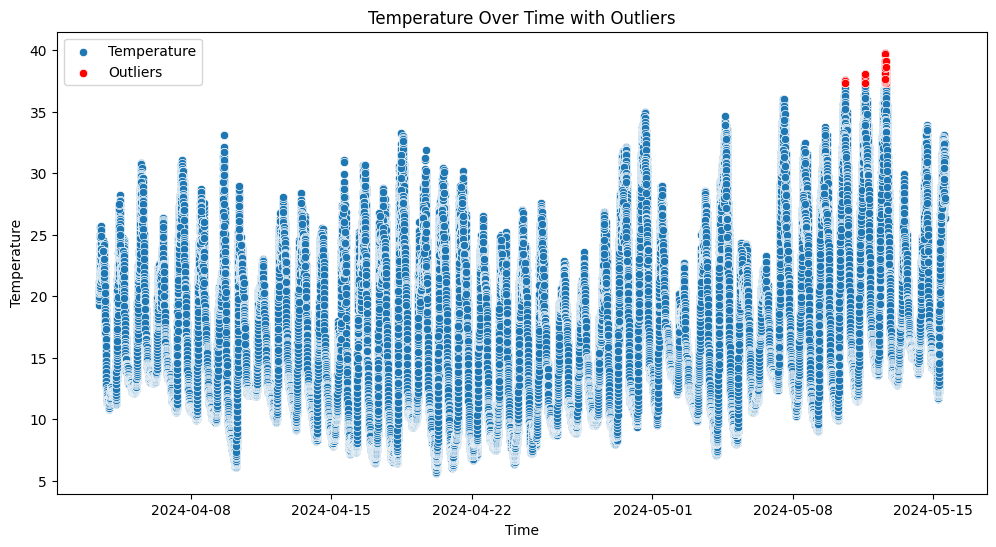

In [35]:
# Visualize the outliers
# Plot Temperature with outliers
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Time', y='Temperature', data=combined_data, label='Temperature')
sns.scatterplot(x='Time', y='Temperature', data=outliers, color='red', label='Outliers')
plt.legend()
plt.title('Temperature Over Time with Outliers')
plt.show()

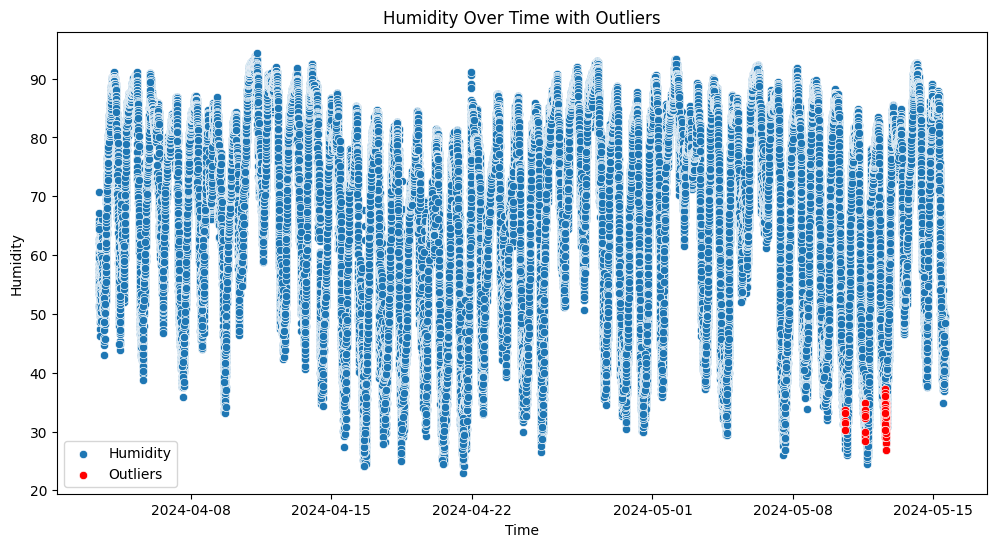

In [36]:
# Plot Humidity with outliers
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Time', y='Humidity', data=combined_data, label='Humidity')
sns.scatterplot(x='Time', y='Humidity', data=outliers, color='red', label='Outliers')
plt.legend()
plt.title('Humidity Over Time with Outliers')
plt.show()